<a href="https://colab.research.google.com/gist/cwkx/c0e7421f470255bb6536e523dba703b5/coursework-pegasus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q torch torchvision livelossplot

**Main imports**

In [0]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Import dataset**

In [0]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
shuffle=True, batch_size=64, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
shuffle=False, batch_size=64, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')

  0%|          | 0/170498071 [00:00<?, ?it/s]

170500096it [00:01, 87140404.82it/s]                               


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
> Size of training dataset 50000
> Size of test dataset 10000


**View some of the test dataset**

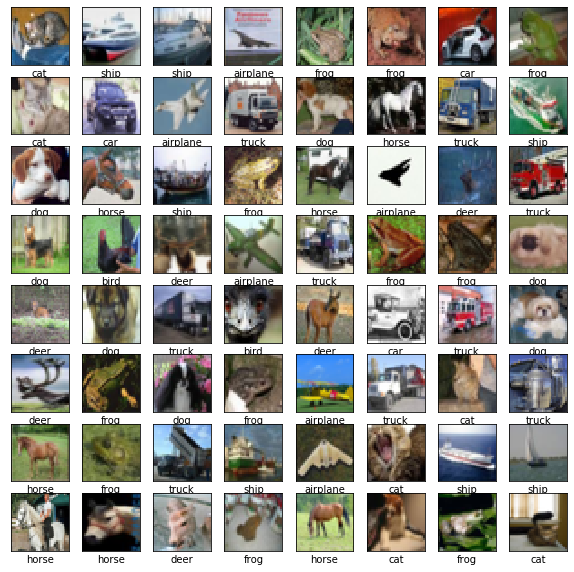

In [0]:
plt.figure(figsize=(10,10))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_loader.dataset[i][0].permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.xlabel(class_names[test_loader.dataset[i][1]])

**Define a simple model**

In [0]:
# define the model (a simple autoencoder)
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        layers = nn.ModuleList()
        layers.append(nn.Linear(in_features=3*32*32, out_features=512))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(in_features=512, out_features=32))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(in_features=32, out_features=512))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(in_features=512, out_features=3*32*32))
        layers.append(nn.Sigmoid())
        self.layers = layers

    def forward(self, x):
        z = self.encode(x)
        x = self.decode(z)
        return x

    # encode (flatten as linear, then run first half of network)
    def encode(self, x):
        x = x.view(x.size(0), -1)
        for i in range(4):
            x = self.layers[i](x)
        return x

    # decode (run second half of network then unflatten)
    def decode(self, x):
        for i in range(4,8):
            x = self.layers[i](x)
        x = x.view(x.size(0), 3, 32, 32)
        return x

N = MyNetwork().to(device)

print(f'> Number of network parameters {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

# initialise the optimiser
optimiser = torch.optim.Adam(N.parameters(), lr=0.001)
epoch = 0
liveplot = PlotLosses()

> Number of network parameters 3182624


**Main training loop**

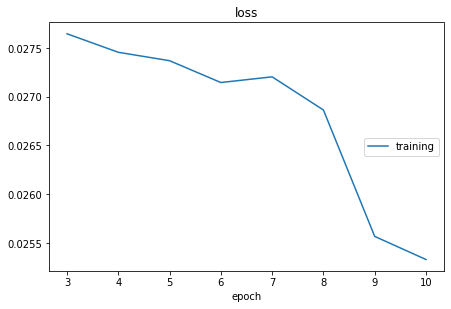

loss:
training   (min:    0.025, max:    0.031, cur:    0.025)


In [0]:
# training loop, feel free to also train on the test dataset if you like for generating the pegasus
while (epoch<10):
    
    # arrays for metrics
    logs = {}
    train_loss_arr = np.zeros(0)

    # iterate over some of the train dateset
    for i in range(1000):
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)

        optimiser.zero_grad()
        p = N(x)
        loss = ((p-x)**2).mean() # simple MSE loss
        loss.backward()
        optimiser.step()

        train_loss_arr = np.append(train_loss_arr, loss.item())

    # plot the loss
    liveplot.update({
        'loss': train_loss_arr.mean()
    })
    liveplot.draw()

    epoch = epoch+1

**Generate a Pegasus, for example by interpolating between the latent space encodings of a horse and a bird**

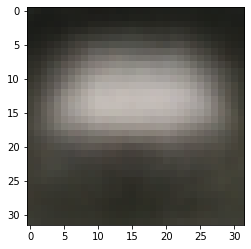

In [0]:
example_1 = test_loader.dataset[13][0].to(device)  # horse
example_2 = test_loader.dataset[160][0].to(device) # bird

example_1_code = N.encode(example_1.unsqueeze(0))
example_2_code = N.encode(example_2.unsqueeze(0))

# this is some sad blurry excuse of a Pegasus, hopefully you can make a better one
bad_pegasus = N.decode(0.9*example_1_code + 0.1*example_2_code).squeeze(0)

plt.grid(False)
plt.imshow(bad_pegasus.cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)

#for i in range(len(test_loader.dataset.test_labels)):
#  print(class_names[test_loader.dataset.test_labels[i]] + '\t idx: ' + str(i))

**Sample a batch from the generative model to show the output diversity**

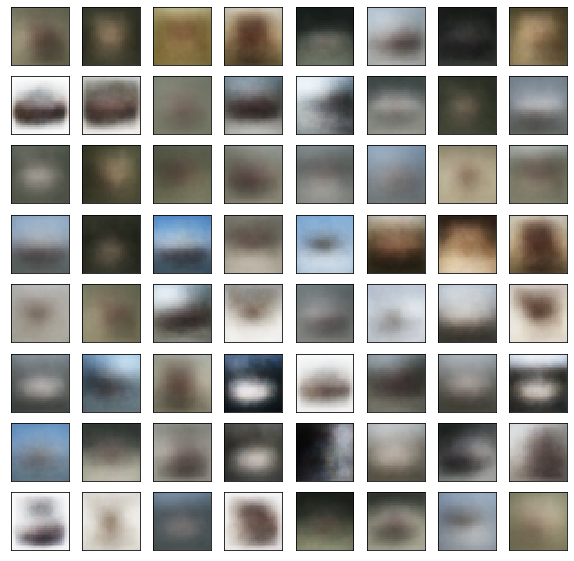

In [0]:
x,t = next(train_iterator)
x,t = x.to(device), t.to(device)
p = N(x)

plt.figure(figsize=(10,10))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(p[i].cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)